In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from typing import Union, List

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *



In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
listings_raw = pd.read_csv("../data/raw/munich/2020-05-24/listings.csv.gz",compression="gzip")
listings_raw.shape

(11128, 106)

In [6]:
listings = listings_raw.copy()

In [7]:
# Mietspiegel Preise 2020 : https://www.wohnungsboerse.net/mietspiegel-Muenchen/2091
#del listings


In [8]:
# Format price
listings["price"] = format_price(listings["price"])
listings["cleaning_fee"] = format_price(listings["cleaning_fee"])
listings["extra_people"] = format_price(listings["extra_people"])

# Drop outliers
listings = listings[listings["price"] < listings["price"].quantile(0.9)]
listings = listings[listings["price"] > listings["price"].quantile(0.01)]

In [9]:
def text_contains_word(df: pd.DataFrame, search_features: Union[str, List[str]], word: Union[str,List[str]], feature_name: str) -> pd.DataFrame:
    """
    Checks if at least one of the given features contains a given word.

    Input:
    - df: pd.DataFrame
    - search_features: names of columns with text data
    - word: str or list of words to search in the features
    - feature_name: name of new feature

    Returns:
    - pd.DataFrame with a new column named after the given words and representing a true/false flag.
    """
    if isinstance(word, list):
        word = [w.lower() for w in word]
        search_term = "|".join(word) # pipe for "or"-search
    else:
        search_term = word.lower()

    df[search_features] = df[search_features].apply(lambda x: x.str.lower())
    df[feature_name] = df[search_features].apply(lambda x: any(x.str.contains(search_term) & x.notna()), axis=1)
    return df

In [10]:
def mean_price(df: pd.DataFrame, feature):
    """Get mean price grouped by the given feature."""
    return df.groupby(feature).price.mean(),df.groupby(feature).price.median(), df[feature].value_counts()

In [11]:
def format_flags(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Format t / f to boolean True and False
    """
    flags = {"t": True, "f": False, "nan": np.NaN}
    for col in columns:
        df[col] = df[col].replace(flags)
        df[col] = df[col].astype(bool)
    return df

In [12]:
def make_dummies(series: pd.Series, name: str, sep="|") -> pd.DataFrame:
    """
    Performs one-hot encoding and renames the resulting columns by prepending the name parameter to column names
    """
    dummies = series.str.get_dummies(sep=sep)
    dummies.columns = name + dummies.columns
    for col in dummies.columns:
        dummies[col] = dummies[col].astype(bool)
    return dummies

In [13]:
# Make description-based feature
words = ["roof top", "roof-top", "Dachterasse","Dachterrasse","roof terrace"]
descriptive_columns = ["space", "description"]
listings = text_contains_word(listings, descriptive_columns, words, "roof_top_terrace")

In [14]:
# Perform one-hot encoding for amenities
amenities = listings_raw.amenities.str.replace("[{""}]", "")\
                    .str.replace("\"", "")
amenities = make_dummies(amenities, name="amenities_",sep=",")
amenities["total_amount_amenities"] = amenities.sum(axis=1)

# Add (one-hot encoded) amenity features to dataset
listings = pd.concat([listings, amenities], axis=1)


(11128, 257)

In [15]:
# Convert host_since to number of month the host is active on AirBnB
listings["host_since_month"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["host_since"])).astype('timedelta64[M]')

In [16]:
listings = text_contains_word(listings, ["host_location"], ["Munich", "München"], "host_in_munich")


In [17]:
response_time_encoding = {"within an hour": 1,
                          "within a few hours": 2,
                          "within a day": 3,
                          "a few days or more": 4,
                          "nan": np.NaN}
listings.host_response_time.replace(response_time_encoding, inplace=True)

In [18]:
# remove %-sign from features containing rates
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%","").astype(float)
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].str.replace("%","").astype(float)



In [19]:
listings["host_in_different_neighbourhood"] = listings["host_neighbourhood"] != listings["neighbourhood"]

In [20]:
neighbourhood_other = listings["host_neighbourhood"].value_counts()[listings["host_neighbourhood"].value_counts()<=20].index
host_neighbourhood = make_dummies(listings["host_neighbourhood"].replace(neighbourhood_other, "other"), name="host_neighbourhood_", sep=" - ")

neighbourhood = make_dummies(listings["neighbourhood"], name="neighbourhood_" , sep=" - ")

listings = pd.concat([listings, host_neighbourhood], axis=1)
listings = pd.concat([listings, neighbourhood], axis=1)

In [21]:
# Get flag columns and reformat 
flag_cols = listings.apply(lambda x: 'f' in x.dropna().unique() or 't' in x.dropna().unique()).loc[lambda x: x==True].index.values
listings = format_flags(listings, flag_cols)

In [22]:
# encode host verification
listings["host_verifications"] = listings["host_verifications"].str.replace("\[|\]|'| ","")#.str.get_dummies(sep=",", drop_first=True)#.sum().sort_values()
host_verification_encoding = make_dummies(listings["host_verifications"], name="", sep=",")
# build a group of encoded host verification with just a few samples
other = host_verification_encoding.sum().loc[lambda x: x<100].index.values
host_verification_encoding["other"] = host_verification_encoding[other].any(axis=1)
host_verification_encoding.drop(columns=other, inplace=True)
host_verification_encoding.columns = "host_verification_" + host_verification_encoding.columns#

listings = pd.concat([listings, host_verification_encoding], axis=1)

In [23]:
listings["property_type"] = listings["property_type"].astype(str)

In [24]:
# Create "category" for categories that occur seldom. Only make an exception for "villa" since the average price niveau for a "villa" is significantly higher.
other_property_types = listings.loc[listings["property_type"]!="Villa","property_type"].value_counts().loc[lambda x: x < 20].index.values
listings["property_type"] = listings["property_type"].apply(lambda x: "other" if any([p_type in x for p_type in other_property_types]) else x)
property_encoding = make_dummies(listings["property_type"], name="property_type_")
listings = pd.concat([listings, property_encoding], axis=1)


In [25]:
# use zipcode directly as discrete variable since the codes provide information about how far away one zipcode is from another
listings["zipcode"] = listings["zipcode"].astype(str).str[:5] # make sure that the zipcode contains 5 digits
listings["zipcode"] = listings["zipcode"].astype(float)

In [26]:
#listings.room_type.value_counts(normalize=True)
room_type = make_dummies(listings["room_type"], name="room_type_")
listings = pd.concat([listings, room_type], axis=1)

In [27]:
#listings.bed_type.value_counts(normalize=True)
bed_type = make_dummies(listings["bed_type"], name="bed_type_")
listings = pd.concat([listings, bed_type], axis=1)

In [28]:
#listings.cancellation_policy.value_counts(normalize=True)
cancellation_policy = make_dummies(listings["cancellation_policy"], name="cancellation_policy_")
listings = pd.concat([listings, cancellation_policy], axis=1)

In [29]:
drop_cols = ['listing_url',
            'scrape_id',
            'last_scraped',
            'thumbnail_url', 
            'medium_url',
            'picture_url', 
            'xl_picture_url',
            'host_thumbnail_url', 
            'host_picture_url',
            'calendar_last_scraped',
            'name',
            'summary',
            'scrape_id',
            'country_code',
            'country',
            'amenities',
            'space',
            'description',
            'id',
            'neighborhood_overview',
            'notes',
            'transit',
            'experiences_offered',
            'host_since',
            'access', 
            'interaction',
            'house_rules',
            'host_id',
            'host_url',
            'host_name',
            'host_location',
            'host_about',
            'host_neighbourhood',
            'neighbourhood',
            'host_verifications',
            'street',
            'zipcode',
            'city',
            'market', 
            'smart_location',
            'property_type',
            'state',
            'weekly_price',
            'monthly_price',
            'security_deposit',
            #'cleaning_fee',
            #'extra_people',
            'calendar_updated',
            'first_review',
            'last_review',
            'bed_type',
            'room_type',
            'cancellation_policy',
            #'neighbourhood_cleansed',
            'license',
            ]
listings.drop(columns=drop_cols, inplace=True)

In [30]:
listings[["latitude","longitude"]]

latitude  longitude
0      48.13057   11.56929
1      48.12456   11.55567
2      48.11476   11.48782
3      48.11923   11.63726
4      48.15198   11.56486
...         ...        ...
11123  48.17704   11.53200
11124  48.13999   11.51712
11125       NaN        NaN
11126  48.16079   11.58875
11127  48.15278   11.57950

[11128 rows x 2 columns]

In [31]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    See:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-pointshttps://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_to_point_of_interest(df):
    points_of_interest = {"oktoberfest_geo_location": (48.130910, 11.548901),
    "munich_main_station_geo_location": (48.140283, 11.560488),
    "munich_hofbraeuhaus_geo_location": (48.137612, 11.579911),
    "munich_englischer_garten_geo_location": ( 48.152066, 11.592246 ),
    "munich_deutsches_museum_geo_location": ( 48.129929, 11.583482 )}

    for poi, coords in points_of_interest.items():
        df[poi] = df.apply(lambda x: haversine(x["longitude"], x["latitude"], coords[1], coords[0]), axis=1)

    return df

In [32]:
listings = distance_to_point_of_interest(listings)

In [33]:
listings["average_poi_distance"] = listings.apply(lambda x: x[x.index.str.contains("geo_location")].mean(),axis=1)

In [45]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(listings[["latitude","longitude"]], (lambda u,v: haversine(u[1], u[0],v[1],v[0]))))

db = DBSCAN(eps=0.1, min_samples=10, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
result = db.fit_predict(distance_matrix)


In [34]:
listings = listings.dropna(subset=["latitude","longitude"])

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=57)
result = kmeans.fit_predict(listings[["latitude","longitude"]])

In [45]:
listings["geo_cluster"] = result

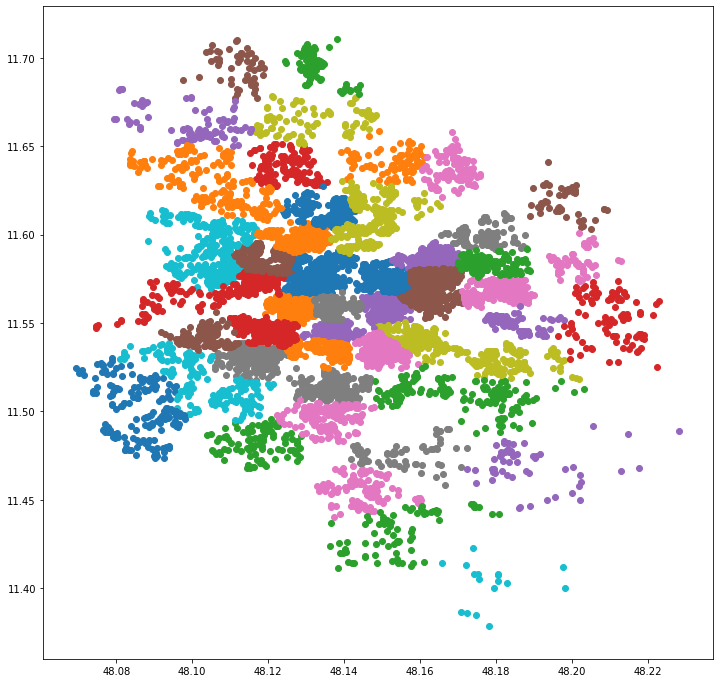

In [310]:
plt.figure(figsize=(12,12))
for cl in listings.geo_cluster.unique():
    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"])
plt.show()

In [46]:
# Drop columns with >50% NaNs
listings.drop(columns=(listings.isna().sum() / len(listings)).loc[lambda x: x>0.5].index.values, inplace=True)

In [47]:
listings_copy = listings.copy()

In [232]:
listings = listings_copy.copy()

In [331]:
listings.drop(columns=["latitude","longitude"], inplace=True)

In [48]:
# Remove features with only one observed value
listings.drop(columns=listings.apply(lambda x: x.nunique() <= 1).loc[lambda x: x==True].index.values, inplace=True)

array([0], dtype=int64)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

listings = shuffle(listings)
X_train, X_test, y_train, y_test = train_test_split(listings, listings["price"], test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(listings[features[:20]], listings["price"], test_size=0.25, random_state=42)

In [99]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



# Create a imputer to replace missing values of numerical features with mean
numeric_features = X_train.drop(columns=["price"]).select_dtypes(np.number).columns
#numeric_features = X_train.select_dtypes(np.number).columns

#numeric_features = listings[features[:20]].select_dtypes(np.number).columns

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = KNNImputer(n_neighbors=3, weights="uniform")
imp = imp.fit(X_train[numeric_features])

neighbourhood_mean_encoding = X_train.groupby("neighbourhood_cleansed")["price"].mean().to_dict()
X_train["neighbourhood_mean_encoding"] = X_train["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)
X_test["neighbourhood_mean_encoding"] = X_test["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)

X_train = X_train.drop(columns = ["neighbourhood_cleansed", "price"])
X_test = X_test.drop(columns = ["neighbourhood_cleansed", "price"])

X_train[numeric_features] = imp.transform(X_train[numeric_features])
X_test[numeric_features] = imp.transform(X_test[numeric_features])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

fs = SelectKBest(score_func=mutual_info_regression, k=100)
fs.fit(X_train, y_train)
X_train = X_train.loc[:,X_train.columns[fs.get_support()]]
X_test = X_test.loc[:,X_test.columns[fs.get_support()]]
print(X_train.columns)

lin_reg = LinearRegression().fit(X_train, y_train)
lin_y_pred = lin_reg.predict(X_test)
print("Linear Regression")
print("R2: {}".format(r2_score(y_test, lin_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, lin_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, lin_y_pred)))


rf_reg = RandomForestRegressor(n_estimators=600, max_depth=20).fit(X_train, y_train)
rf_y_pred = rf_reg.predict(X_test)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_test, rf_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, rf_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, rf_y_pred)))




Index(['host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'reviews_per_month',
       'amenities_Buzzer/wireless intercom', 'amenities_Coffee maker',
       'amenities_D

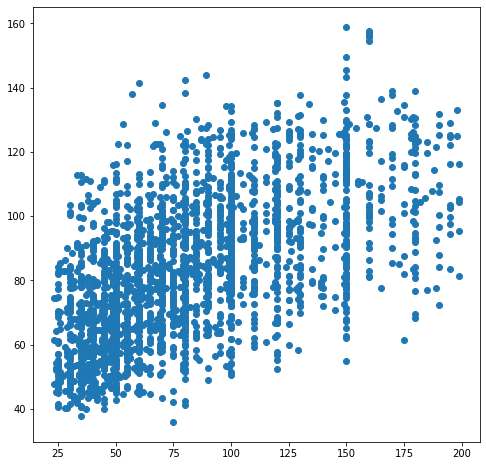

In [101]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, rf_y_pred)
plt.show()

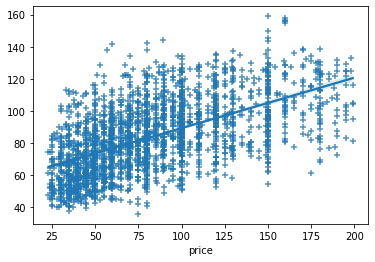

In [102]:
import seaborn as sns
sns.regplot(x=y_test, y=rf_y_pred, marker="+")

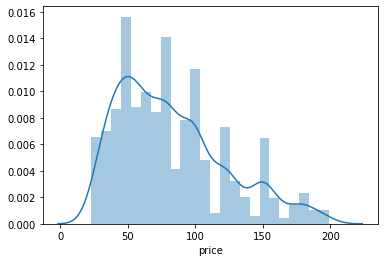

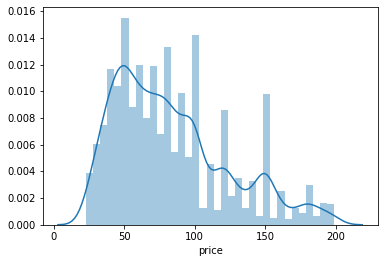

In [118]:
sns.distplot(y_test)
plt.show()
sns.distplot(y_train)
plt.show()

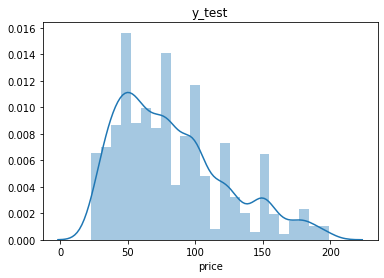

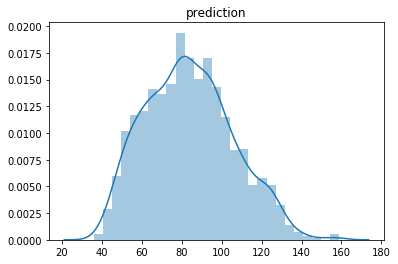

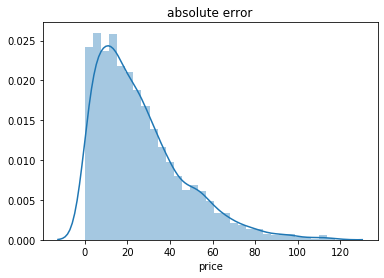

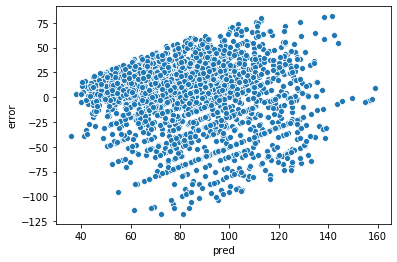

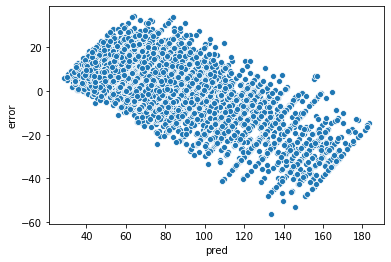

In [117]:
sns.distplot(y_test)
plt.title("y_test")
plt.show()
sns.distplot(rf_y_pred)
plt.title("prediction")
plt.show()
sns.distplot(abs(rf_y_pred-y_test))
plt.title("absolute error")
plt.show()
sns.scatterplot(x=rf_y_pred, y=rf_y_pred-y_test)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()
sns.scatterplot(x=rf_reg.predict(X_train), y=rf_reg.predict(X_train)-y_train)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()

In [100]:
# First train a dummy regressor as most trivial baseline model -> uses mean price of training data as prediction for all airbnbs in the test dataset
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_y_pred = dummy_regr.predict(X_test)
print("Dummy Regression")
print("R2: {}".format(r2_score(y_test, dummy_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, dummy_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, dummy_y_pred)))


Dummy Regression
R2: -0.00024181697805891744
MAE: 32.61334228515625
MSE: 1609.5135498046875


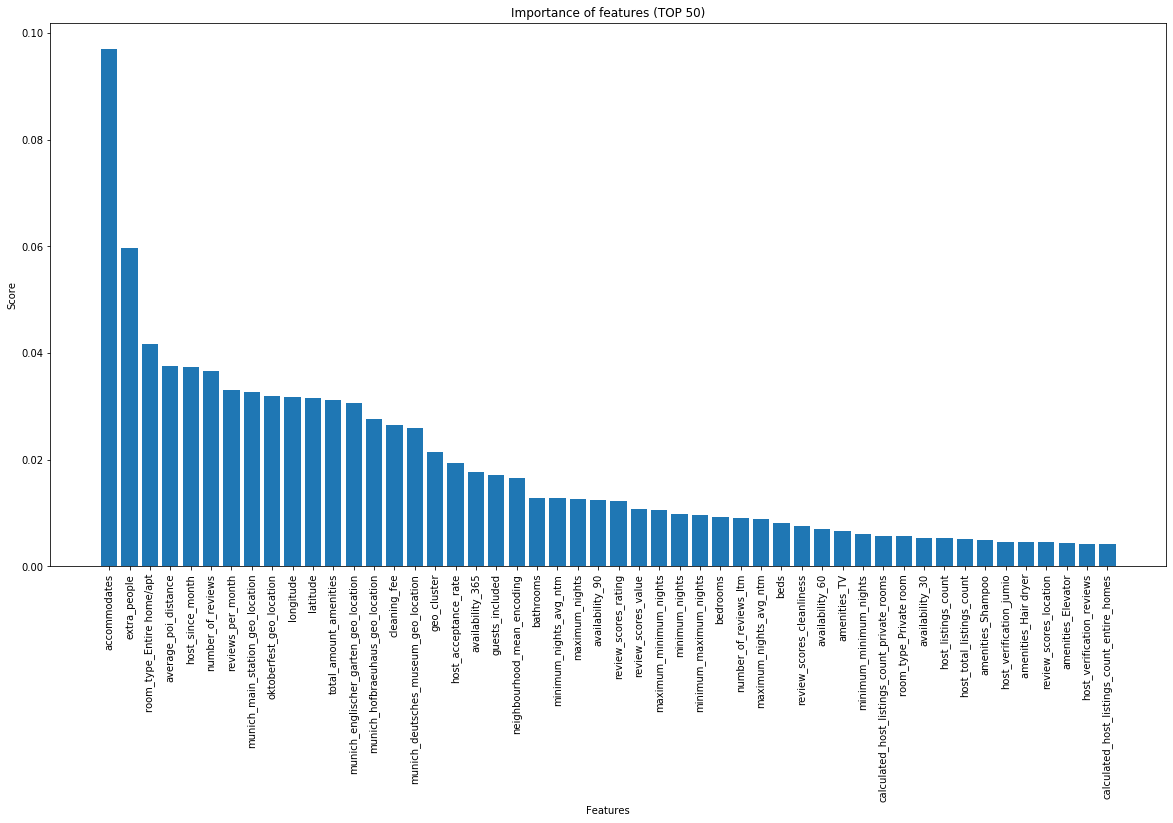

In [69]:
# Sort the importance of the features
importances = reg.feature_importances_
    
values = sorted(zip(X_train.columns, reg.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:50]
y_feature = np.arange(len(features))
score = feature_importances['score'][:50]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 50)');

In [71]:
import shap


In [76]:
reg

RandomForestRegressor(max_depth=20, n_estimators=600)

In [83]:
subset = shuffle(pd.concat([X_train, X_test]))[:100]

In [84]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(subset)


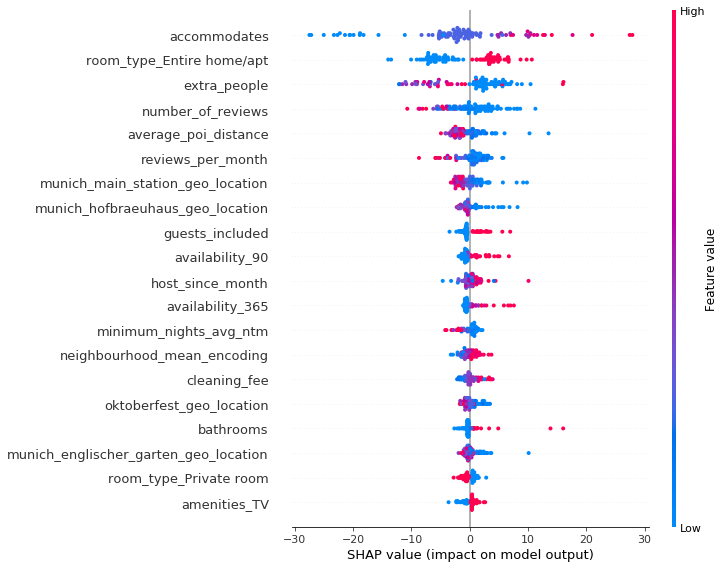

In [85]:
shap.summary_plot(shap_values, subset)

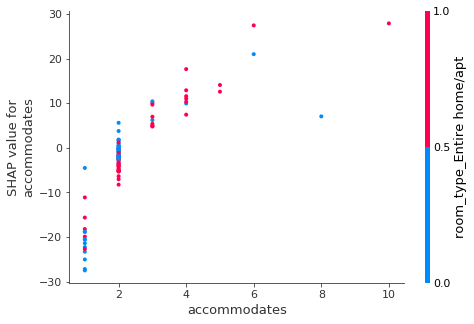

In [86]:
shap.dependence_plot("accommodates", shap_values, subset)

In [91]:
shap.force_plot(shap_va)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [87]:
y_pred = reg.predict(X_train)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_train, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_train, y_pred)))

Random Forest Regression
R2: 0.8945220204069843
MAE: 10.290993689269886
